In [171]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import lxml.etree as ET
from bs4 import BeautifulSoup
import os
import spacy
import string
import re
import numpy as np
from spacy.symbols import ORTH
from pathlib import Path
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import cv2
import matplotlib.pyplot as plt

In [172]:
IMG_PATH = Path("./generative-dog-images/all-dogs")
ANNOT_PATH = Path("./generative-dog-images/Annotation")
list(IMG_PATH.iterdir())[:10]

[PosixPath('generative-dog-images/all-dogs/n02109961_16718.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02113799_5009.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02091032_6587.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02106166_1429.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02093754_2276.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02107683_4411.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02094114_2625.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02088094_8631.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02097130_1289.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02095314_3084.jpg')]

In [173]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

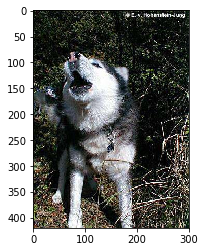

In [174]:
path = PATH/"n02109961_16718.jpg"
im = read_image(path)
plt.imshow(im)

In [175]:
im = cv2.imread(str(path))
im.shape

(420, 300, 3)

In [176]:
# let's look at the typical size of these images
images = list(IMG_PATH.iterdir())
annot_folders = list(ANNOT_PATH.iterdir())
annotations = []
for folder in annot_folders:
    breed_annots = list(folder.iterdir())
    annotations += breed_annots

In [177]:
images.sort(key = lambda x: str(x)[30:])
annotations.sort(key = lambda x: str(x)[33:])

In [178]:
images[:10]

[PosixPath('generative-dog-images/all-dogs/n02085620_10074.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10131.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10621.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_1073.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_10976.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11140.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11238.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11258.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11337.jpg'),
 PosixPath('generative-dog-images/all-dogs/n02085620_11477.jpg')]

In [179]:
len(images)

20579

In [180]:
annotations[:10]

[PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10074'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10131'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10621'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_1073'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_10976'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11140'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11238'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11258'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11337'),
 PosixPath('generative-dog-images/Annotation/n02085620-Chihuahua/n02085620_11477')]

In [181]:
len(annotations)

20580

In [182]:
annots_names = [str(x)[33:].split('/')[1] for x in annotations]
img_names = [str(x)[31:][:-4] for x in images]
set(annots_names)-set(img_names)

{'n02105855_2933'}

In [183]:
[str(x) for x in annotations].index('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

13680

In [184]:
annotations.pop(13680)

PosixPath('generative-dog-images/Annotation/n02105855-Shetland_sheepdog/n02105855_2933')

In [185]:
len(annotations)

20579

In [186]:
for i in range(len(annotations)):
    if str(images[i])[31:][:-4] != str(annotations[i])[33:].split('/')[1]:
        print(i)

In [187]:
for i in range(len(annotations)):
    with open(annotations[i]) as file:  
        data = file.read()
    parser = ET.XMLParser(recover=True)
    tree = ET.ElementTree(ET.fromstring(data, parser=parser))
    for object in tree.findall('object'):
        breeds = []
        breeds.append(object.find('name').text)
    annotations[i] = breeds[0]

In [189]:
annotations[:10]

['Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua',
 'Chihuahua']

In [190]:
len(annotations)

20579

### Dataset

In [191]:
puppy_data = pd.DataFrame(list(zip(images, annotations)), columns =['Image_Path', 'Breed']) 

In [192]:
puppy_data.head()

,Image_Path,Breed
0,generative-dog-images/all-dogs/n02085620_10074...,Chihuahua
1,generative-dog-images/all-dogs/n02085620_10131...,Chihuahua
2,generative-dog-images/all-dogs/n02085620_10621...,Chihuahua
3,generative-dog-images/all-dogs/n02085620_1073.jpg,Chihuahua
4,generative-dog-images/all-dogs/n02085620_10976...,Chihuahua


In [327]:
class PuppyBreedDataset(Dataset):
    def __init__(self, data):
        self.num_files = len(data)
        self.data = data
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx,:]
        y = row['Breed']
        print(y)
        img_path = row['Image_Path']
        print(img_path)
        x = read_image(str(img_path))
        x = cv2.resize(x, (100, 100))
        return np.rollaxis(x, 2), y

In [328]:
train_ds = PuppyBreedDataset(puppy_data)

In [329]:
len(train_ds)

20579

In [330]:
x, y = train_ds[2]
x.shape, y

Chihuahua
generative-dog-images/all-dogs/n02085620_10621.jpg


((3, 100, 100), 'Chihuahua')

In [331]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [332]:
len(train_loader)

322

### Model

In [333]:
resnet = models.resnet34(pretrained=True)
#resnet

In [334]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [335]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [336]:
model = Net()

In [337]:
x, y = next(iter(train_loader))

Bernese_mountain_dog
generative-dog-images/all-dogs/n02107683_2758.jpg
Siberian_husky
generative-dog-images/all-dogs/n02110185_5143.jpg
collie
generative-dog-images/all-dogs/n02106030_7453.jpg
miniature_pinscher
generative-dog-images/all-dogs/n02107312_3980.jpg
Italian_greyhound
generative-dog-images/all-dogs/n02091032_4659.jpg
Ibizan_hound
generative-dog-images/all-dogs/n02091244_3346.jpg
groenendael
generative-dog-images/all-dogs/n02105056_2194.jpg
Newfoundland
generative-dog-images/all-dogs/n02111277_7395.jpg
Yorkshire_terrier
generative-dog-images/all-dogs/n02094433_3642.jpg
Pomeranian
generative-dog-images/all-dogs/n02112018_6129.jpg
malamute
generative-dog-images/all-dogs/n02110063_9360.jpg
dhole
generative-dog-images/all-dogs/n02115913_4129.jpg
Norwich_terrier
generative-dog-images/all-dogs/n02094258_2159.jpg
Great_Pyrenees
generative-dog-images/all-dogs/n02111500_6495.jpg
Labrador_retriever
generative-dog-images/all-dogs/n02099712_4323.jpg
wire-haired_fox_terrier
generative-dog

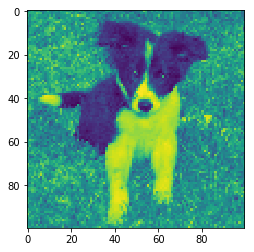

In [343]:
plt.imshow(x[2][0])

In [344]:
y[2]

'collie'

In [349]:
x = x[0].float()
y = y[0]
x.shape

torch.Size([100])

In [350]:
x

tensor([172., 193., 156., 163., 189., 154., 167., 179., 192., 192., 166., 167.,
        145., 169., 174., 171., 181., 155., 179., 167., 188., 199., 155., 177.,
        212., 154., 126., 125., 159., 172., 157., 177., 184., 164., 154., 187.,
        174., 183., 128., 167., 197., 143., 202., 179., 161., 172., 171., 184.,
        160., 142., 153., 172., 146., 136., 143., 181., 126., 172., 130., 144.,
        140., 124., 129., 178., 168., 192., 178., 149., 165., 129., 144., 154.,
        121., 137., 130., 140., 195., 126., 158., 196., 184., 186., 134., 175.,
        135., 158., 187., 135., 104., 125., 143., 130., 148., 174., 148., 173.,
        156., 177., 169., 182.])

In [351]:
x_features = model.features1(x)
x_features.shape

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7, but got 1-dimensional input of size [100] instead